# The Challenge
***

The sinking of the Titanic is one of the most infamous shipwrecks in history.
On April 15, 1912, during her maiden voyage, the widely considered "unsinkable" RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren't enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: "what sorts of people were more likely to survive?" using passenger data (ie name, age, gender, socio-economic class, etc).

In [343]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

sns.set_theme()

SEED = 42

**The following notebook (including chunks of code) follows [this](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial) very closely**

# Import Data
***

First we give a short summary of the number of examples we're dealing with, along with splitting the data into training and test data.

In [344]:
def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
all = concat_df(train, test)

train.name = 'Training Set'
test.name = 'Test Set'
all.name = 'All Set' 

dfs = [train, test]

print('Number of Training Examples = {}'.format(train.shape[0]))
print('Number of Test Examples = {}\n'.format(test.shape[0]))
print('Training X Shape = {}'.format(train.shape))
print('Training y Shape = {}\n'.format(train['Survived'].shape[0]))
print('Test X Shape = {}'.format(test.shape))
print('Test y Shape = {}\n'.format(test.shape[0]))
print(train.columns)
print(test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')



# Overview
***

The data available to us includes:

- PassengerId is the unique id of the row and it doesn't have any effect on target
- Survived is the target variable we are trying to predict (0 or 1):
    - 1 = Survived
    - 0 = Not Survived
- Pclass (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has 3 unique values (1, 2 or 3):
    - 1 = Upper Class
    - 2 = Middle Class
    - 3 = Lower Class
- Name, Sex and Age are self-explanatory
- SibSp is the total number of the passengers' siblings and spouse
- Parch is the total number of the passengers' parents and children
- Ticket is the ticket number of the passenger
- Fare is the passenger fare
- Cabin is the cabin number of the passenger
- Embarked is port of embarkation and it is a categorical feature which has 3 unique values (C, Q or S):
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton

It seems that we have missing values in both our train and test sets, as can be seen below. We will decide how to impute these missing values in the next section.

In [345]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [346]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None



# Missing Values
***

We will now explore the data with missing values in greater detail. From the code below it is clear that we:
- Training set have missing values in Age, Cabin and Embarked columns
- Test set have missing values in Age, Cabin and Fare columns

The count of missing values in Age, Embarked and Fare are smaller compared to total sample, but roughly 80% of the Cabin is missing. Missing values in Age, Embarked and Fare can be filled with descriptive statistical measures but that wouldn't work for Cabin.

In [347]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




### Imputing the missing Age data
***

We begin by focusing on the missing `Age` data. From the following code it is clear that the `Age` data is correlated with the `Pclass` data (the socio-economic status of the passenger). The `Age` data is also correlated with the passenger's Sex.

In [348]:
# Compute correlations
all_corr = all.corr(numeric_only=True).abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()

# Display the correlations with the Age data only
all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
all_corr[all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
0,Age,Age,1.000000
9,Age,Pclass,0.408106
18,Age,SibSp,0.243699
21,Age,Fare,0.178740
26,Age,Parch,0.150917
30,Age,Survived,0.077221
41,Age,PassengerId,0.028814


Thus, we detect the median age of the passengers once grouped by `Sex` and `Pclass`. We use this median to impute the missing `Age` data.

In [349]:
ageByPclassSex = all.groupby(['Sex', 'Pclass'])['Age'].median()

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, ageByPclassSex[sex][pclass]))
print('Median age of all passengers: {}'.format(all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
all['Age'].fillna(all.groupby(["Sex","Pclass"])['Age'].transform('median'),inplace=True)


Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


### Imputing miss Embarked data
***

Next we impute the missing Embarked data. By googling the name of the missing passenger we see they boarded from Southampton.

In [350]:
all[all['Embarked'].isnull()]

# Filling the missing values in Embarked with S 
all['Embarked'] = all['Embarked'].fillna('S')
all[all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [351]:
med_fare = all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
all['Fare'] = all['Fare'].fillna(med_fare)

### Imputing missing Cabin data
***

Originally I dropped the Cabin data as 75% if it is missing. However, [Gunes Evitan](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/notebook) came up with the following code to impute the data in a sensible way.


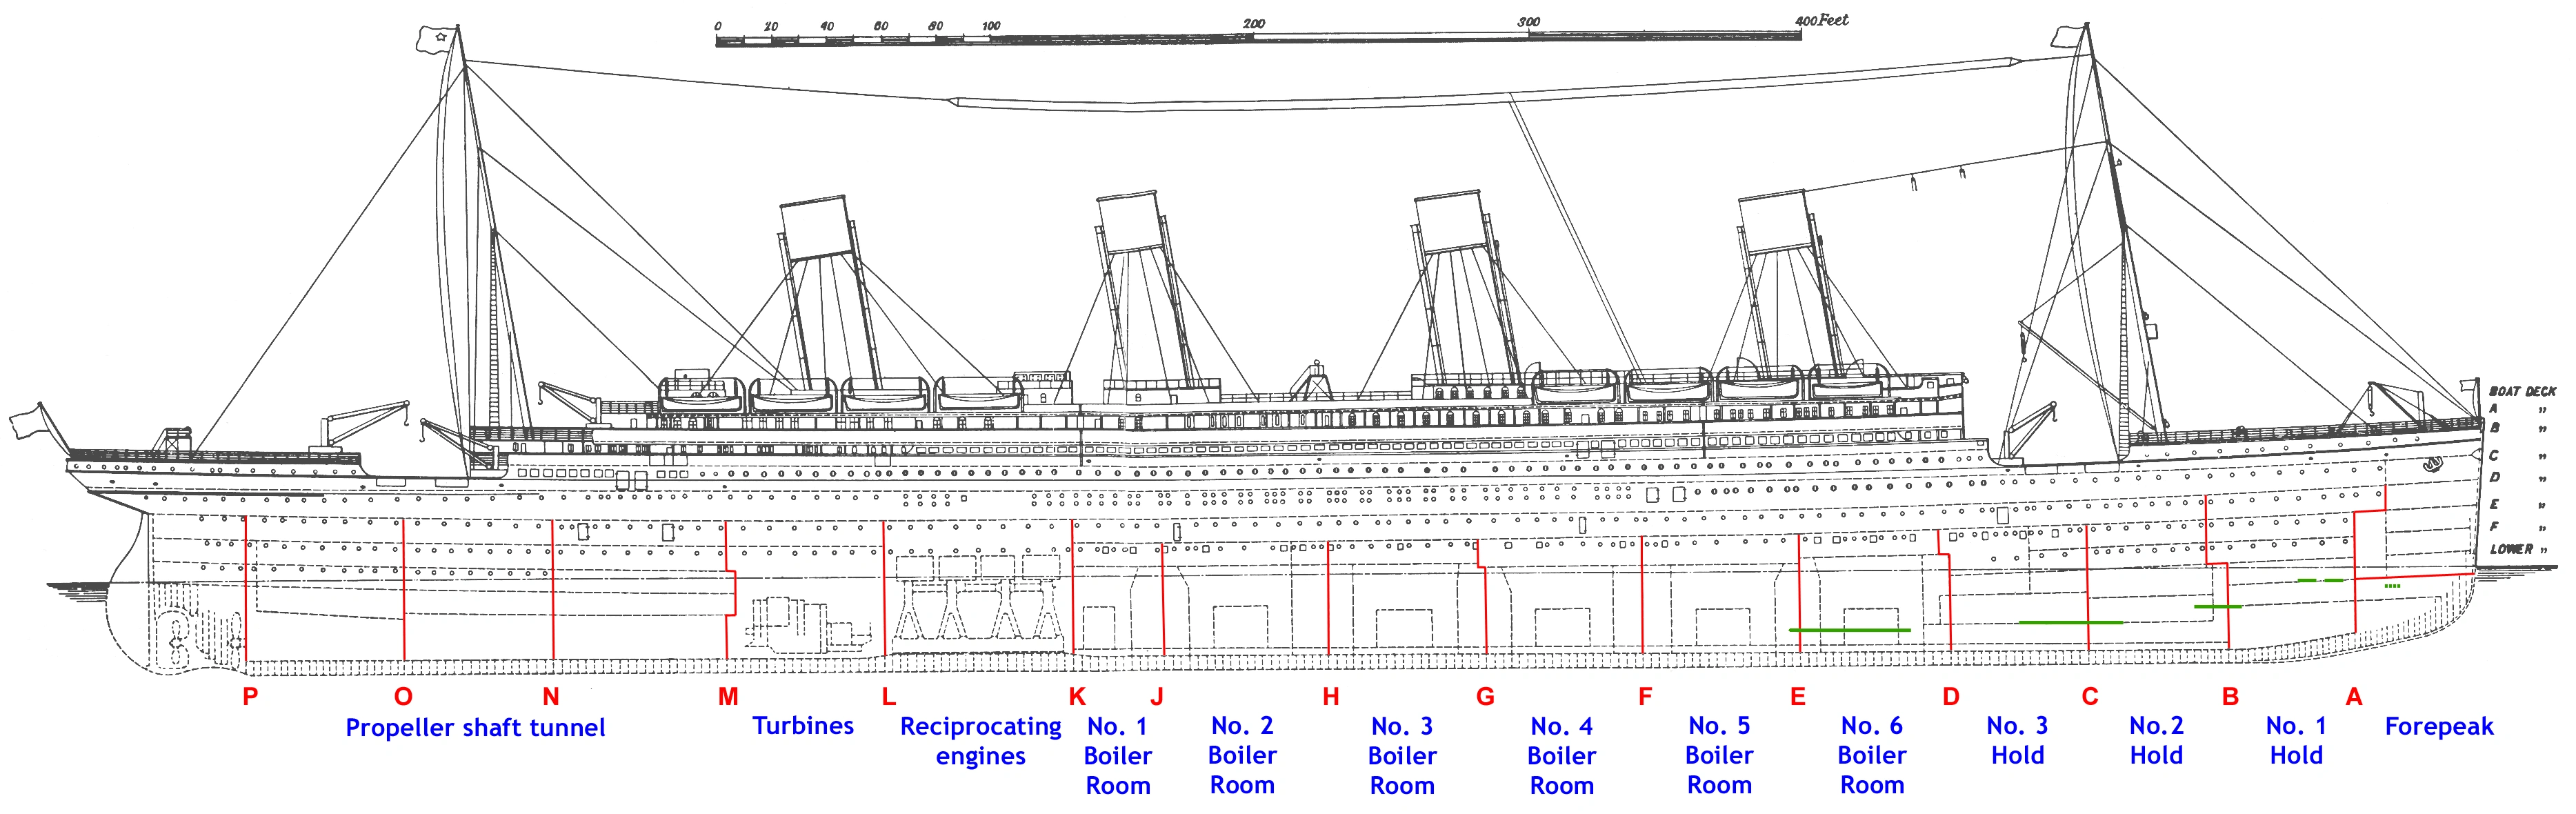


- On the Boat Deck there were 6 rooms labeled as T, U, W, X, Y, Z but only the T cabin is present in the dataset
- A, B and C decks were only for 1st class passengers
- D and E decks were for all classes
- F and G decks were for both 2nd and 3rd class passengers
- From going A to G, distance to the staircase increases which might be a factor of survival


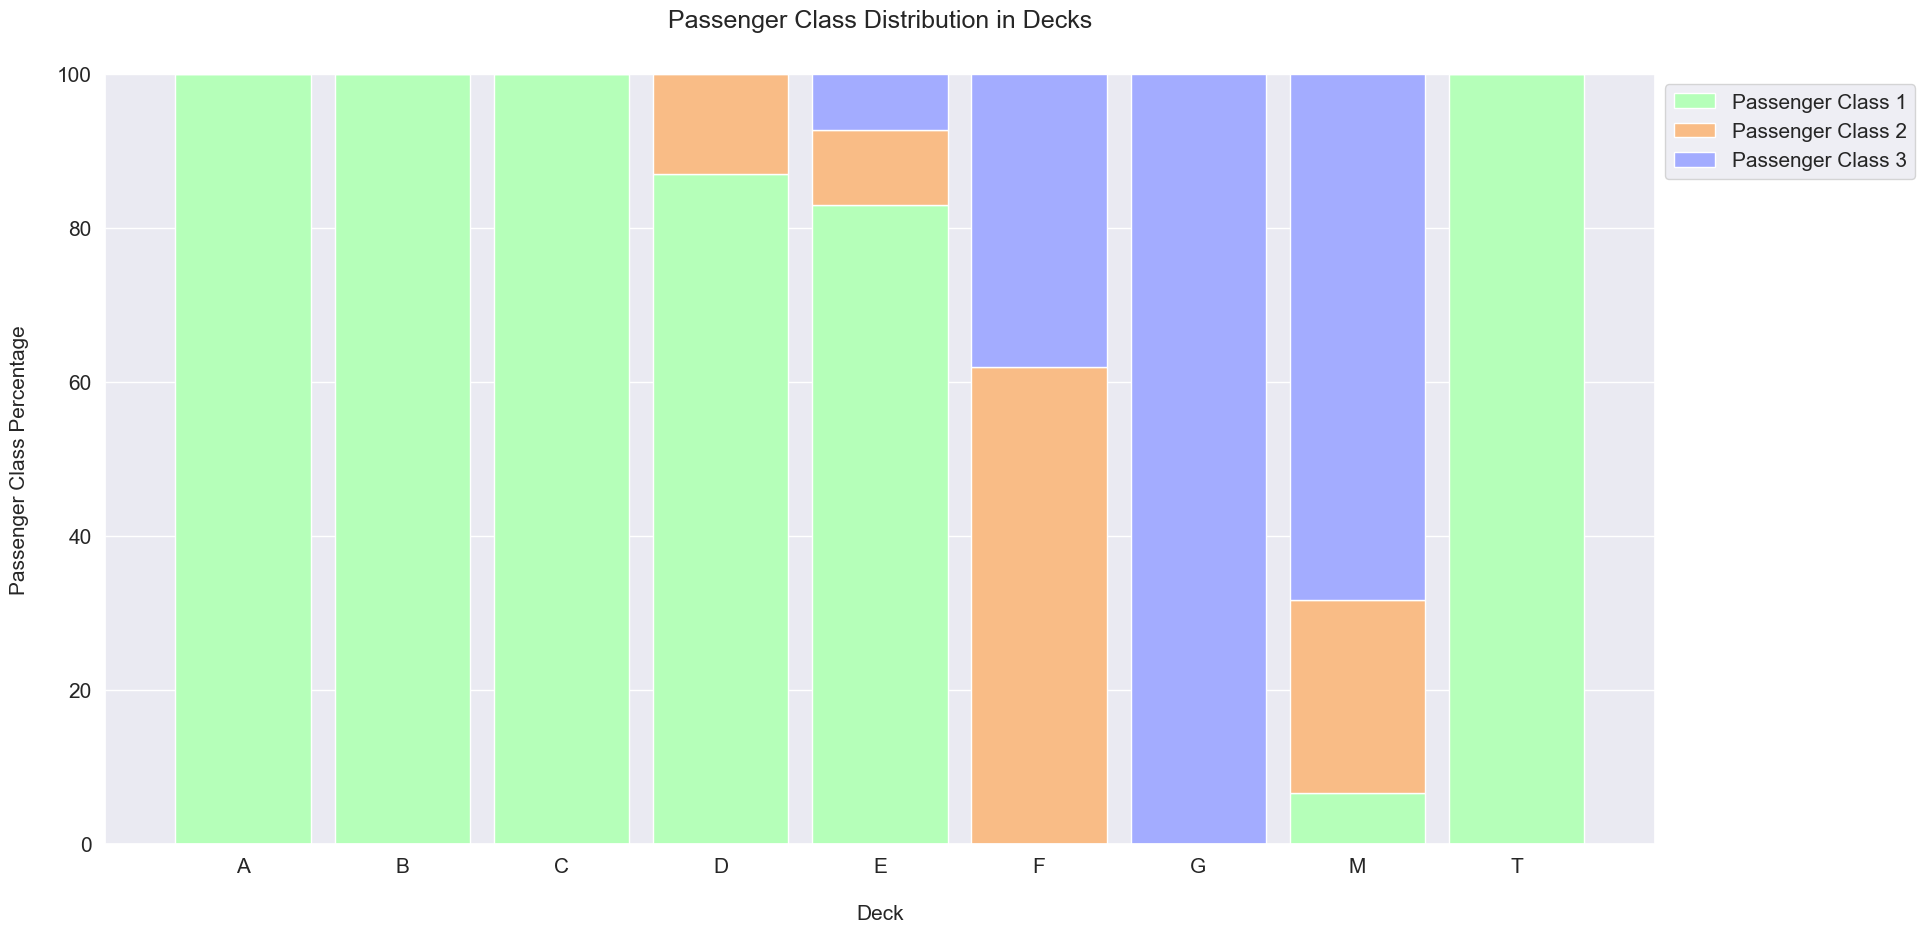

In [352]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
all['Deck'] = all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

all_decks = all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in decks.columns:
        deck_percentages[col] = [(count / decks[col].sum()) * 100 for count in decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = percentages[0]
    pclass2 = percentages[1]
    pclass3 = percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(all_decks)
display_pclass_dist(all_deck_per)



- 100% of A, B and C decks are 1st class passengers
- Deck D has 87% 1st class and 13% 2nd class passengers
- Deck E has 83% 1st class, 10% 2nd class and 7% 3rd class passengers
- Deck F has 62% 2nd class and 38% 3rd class passengers
- 100% of G deck are 3rd class passengers
- There is one person on the boat deck in T cabin and he is a 1st class passenger. T cabin passenger has the closest resemblance to A deck passengers so he is grouped with A deck
- Passengers labeled as M are the missing values in Cabin feature. I don't think it is possible to find those passengers' real Deck so I decided to use M like a deck



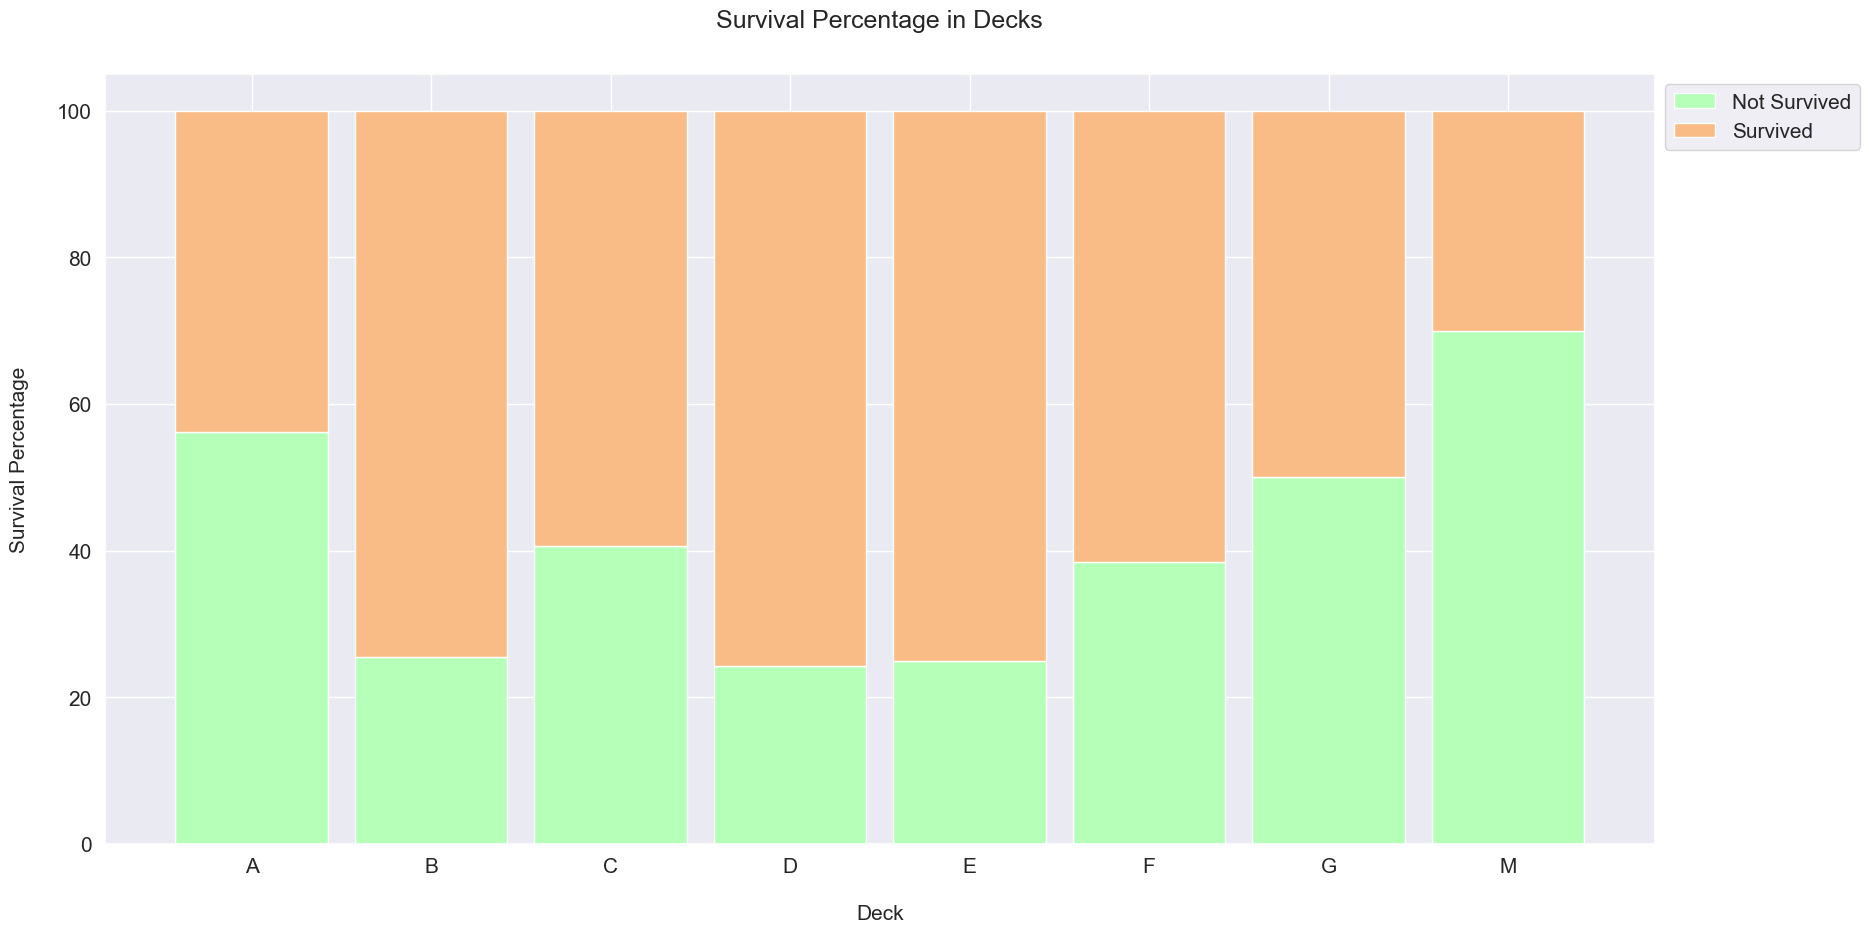

In [353]:
# Passenger in the T deck is changed to A
idx = all[all['Deck'] == 'T'].index
all.loc[idx, 'Deck'] = 'A'

all_decks_survived = all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in surv.columns:
        surv_percentages[col] = [(count / surv[col].sum()) * 100 for count in surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = survived_percentages[0]
    survived = survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(all_decks_survived)
display_surv_dist(all_surv_per)


- A, B and C decks are labeled as ABC because all of them have only 1st class passengers
- D and E decks are labeled as DE because both of them have similar passenger class distribution and same survival rate
- F and G decks are labeled as FG because of the same reason above
- M deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.


In [354]:
all['Deck'] = all['Deck'].replace(['A', 'B', 'C'], 'ABC')
all['Deck'] = all['Deck'].replace(['D', 'E'], 'DE')
all['Deck'] = all['Deck'].replace(['F', 'G'], 'FG')

all['Deck'].value_counts()

Deck
M      1014
ABC     182
DE       87
FG       26
Name: count, dtype: int64

Cabin is dropped because Deck feature is used instead of it.

In [355]:
# Dropping the Cabin feature
all.drop(['Cabin'], inplace=True, axis=1)

train, test = divide_df(all)
dfs = [train, test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




### Correlations
***

Next we explore correlations between features.

In [356]:
train_corr = train.drop(['PassengerId'], axis=1).corr(numeric_only=True).abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
train_corr.drop(train_corr.iloc[1::2].index, inplace=True)
train_corr_nd = train_corr.drop(train_corr[train_corr['Correlation Coefficient'] == 1.0].index)

test_corr = test.corr(numeric_only=True).abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
test_corr.drop(test_corr.iloc[1::2].index, inplace=True)
test_corr_nd = test_corr.drop(test_corr[test_corr['Correlation Coefficient'] == 1.0].index)

# Training set high correlations
corr = train_corr_nd['Correlation Coefficient'] > 0.1
train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.549500
8,Age,Pclass,0.417667
10,Parch,SibSp,0.414838
12,Pclass,Survived,0.338481
14,Fare,Survived,0.257307
16,Age,SibSp,0.249747
18,Parch,Fare,0.216225
20,Parch,Age,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


We looks at the variables with relatively high correlation only:

In [357]:
# Test set high correlations
corr = test_corr_nd['Correlation Coefficient'] > 0.1
test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.577489
8,Age,Pclass,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Parch,Fare,0.230410
16,Fare,SibSp,0.172032


In [358]:
# Test set high correlations
corr = test_corr_nd['Correlation Coefficient'] > 0.1
test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.577489
8,Age,Pclass,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Parch,Fare,0.230410
16,Fare,SibSp,0.172032


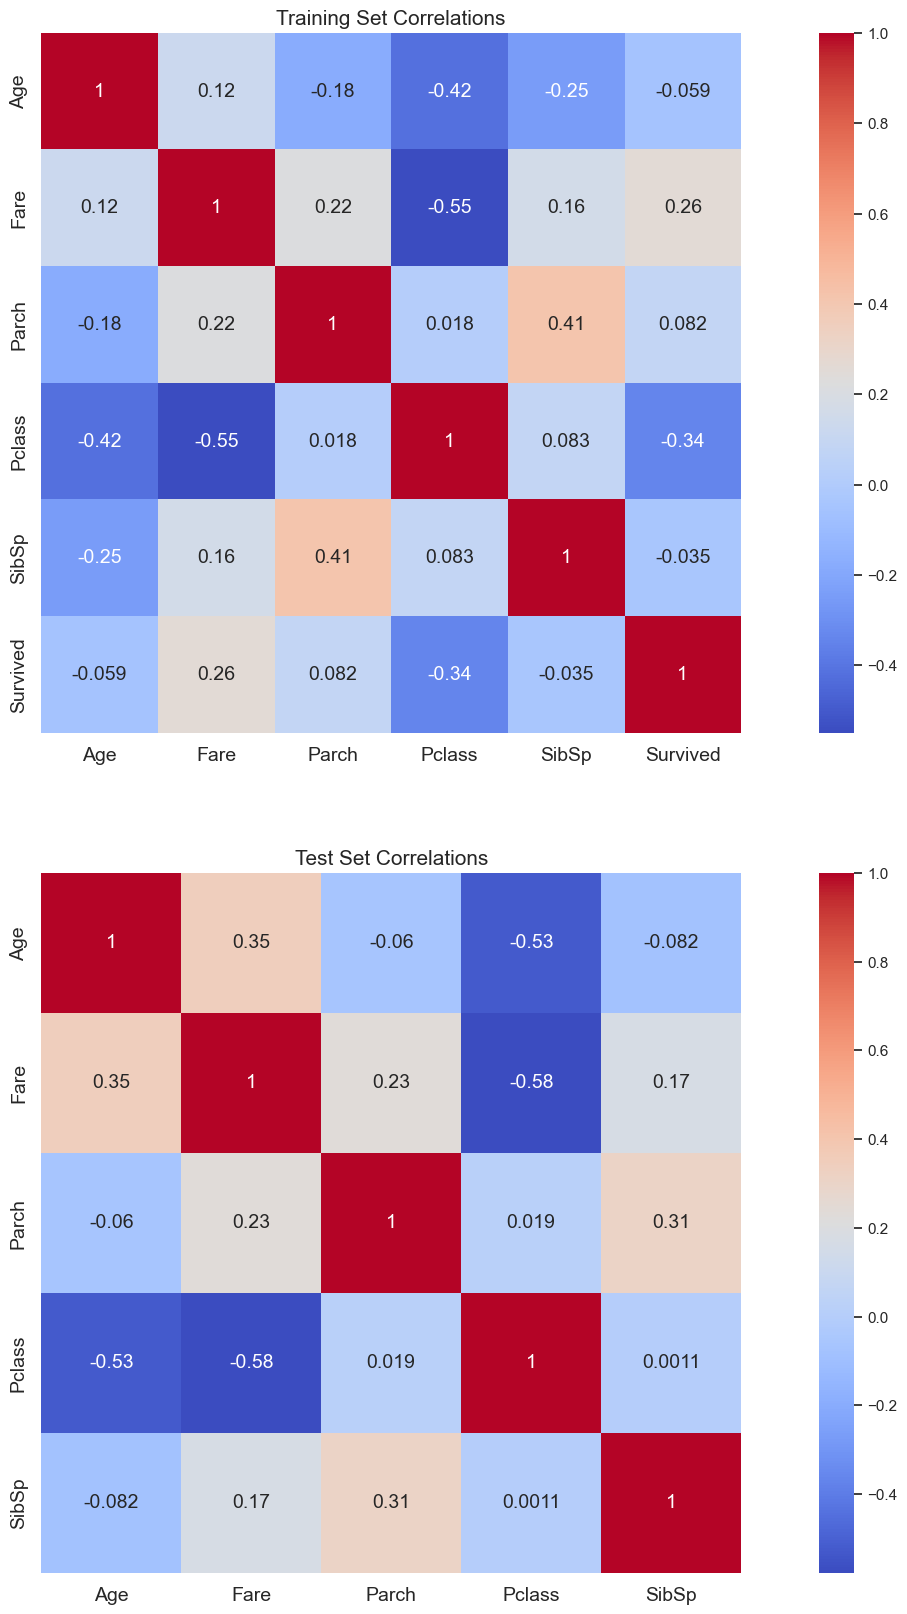

In [359]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(train.drop(['PassengerId'], axis=1).corr(numeric_only=True), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(test.drop(['PassengerId'], axis=1).corr(numeric_only=True), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

## Feature Engineering
***

First we bin the `Fare` and `Age` data.

In [360]:
all = concat_df(train, test)
all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


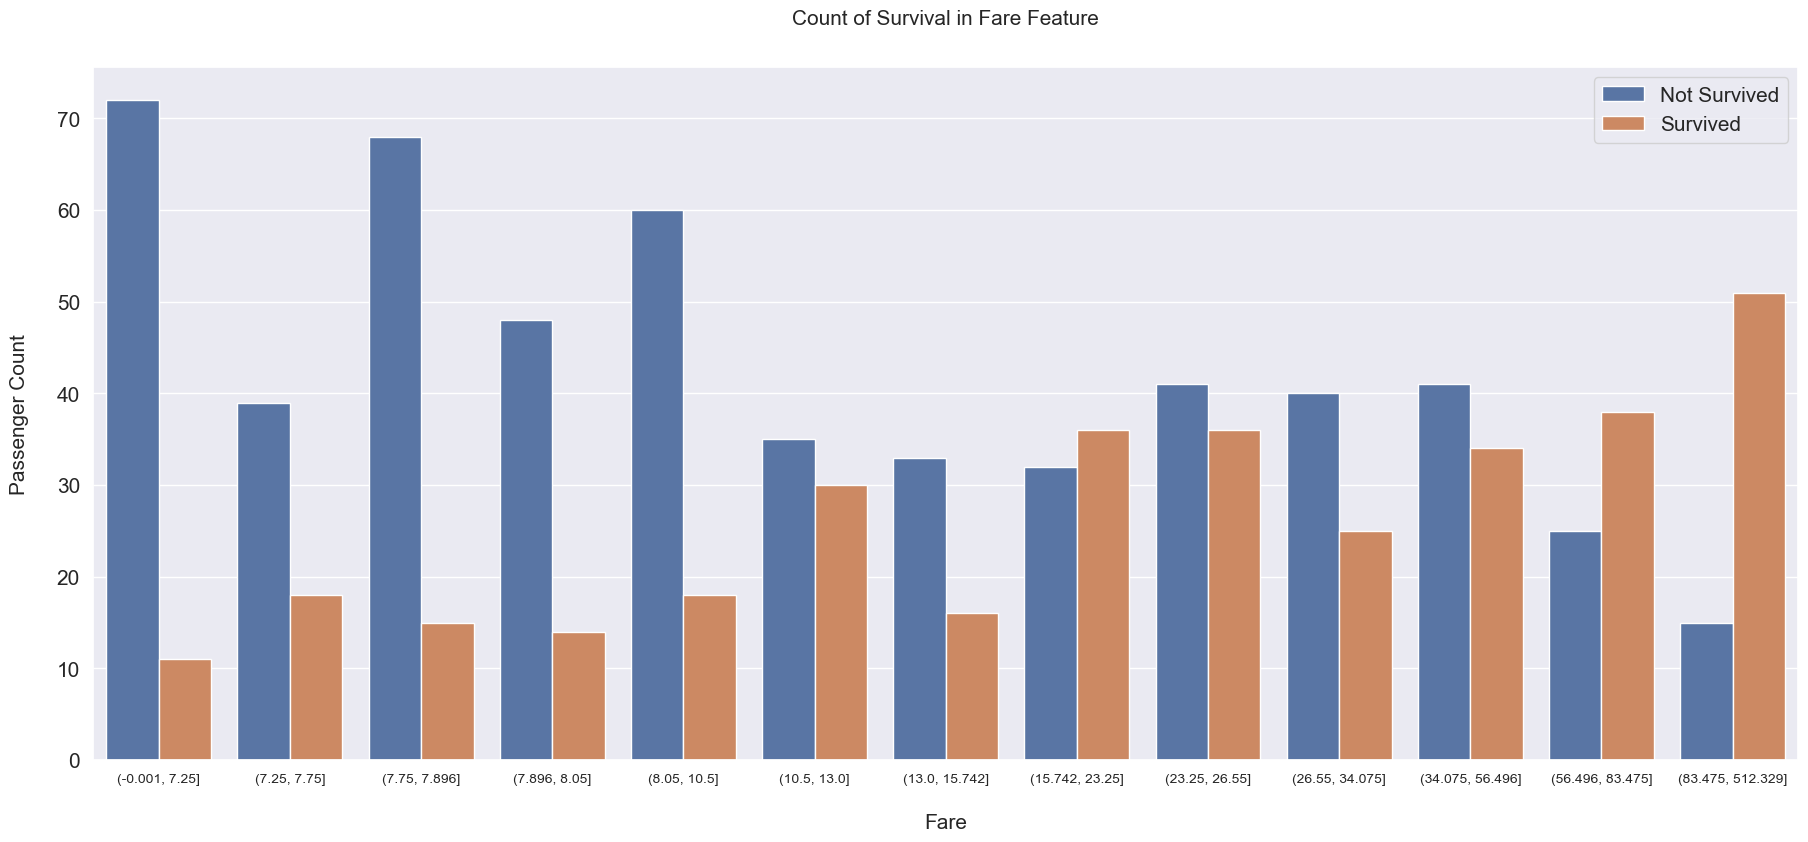

In [361]:
all['Fare'] = pd.qcut(all['Fare'], 13)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

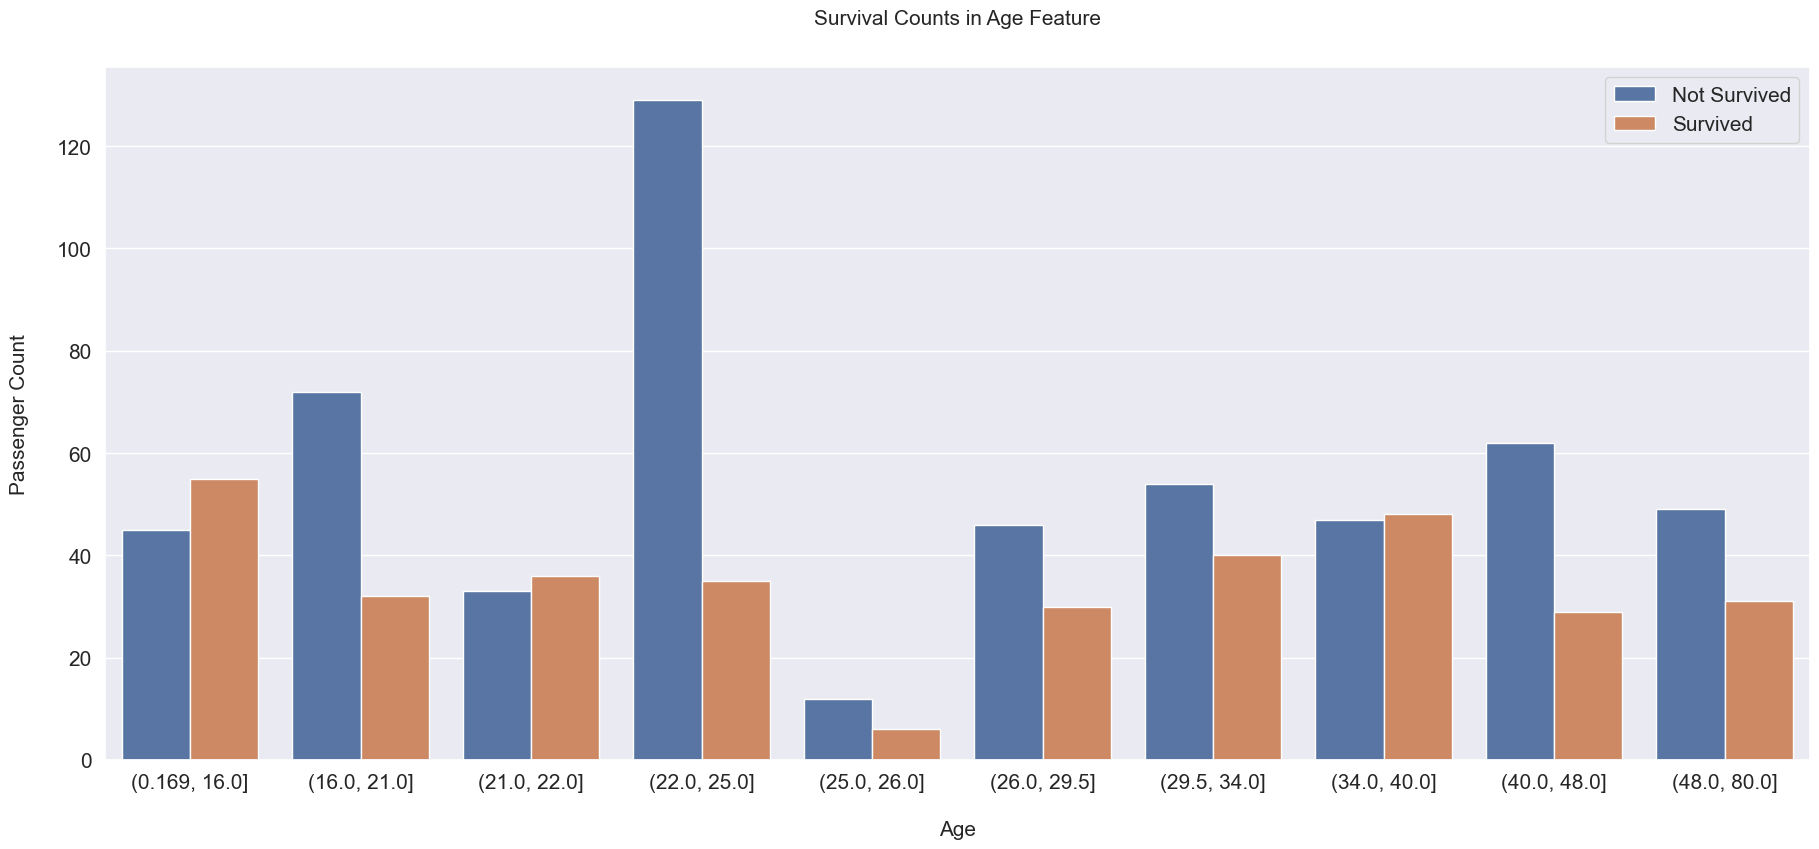

In [362]:
all['Age'] = pd.qcut(all['Age'], 10)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

Next we make a `Family_Size` variable. As many contributors have noted, family size is a predictor of survival because different values have different survival rates. In particular, `Family_Size` is created by adding `SibSp`, `Parch` and `1`. 


- Family Size with 1 are labeled as Alone
- Family Size with 2, 3 and 4 are labeled as Small
- Family Size with 5 and 6 are labeled as Medium
- Family Size with 7, 8 and 11 are labeled as Large

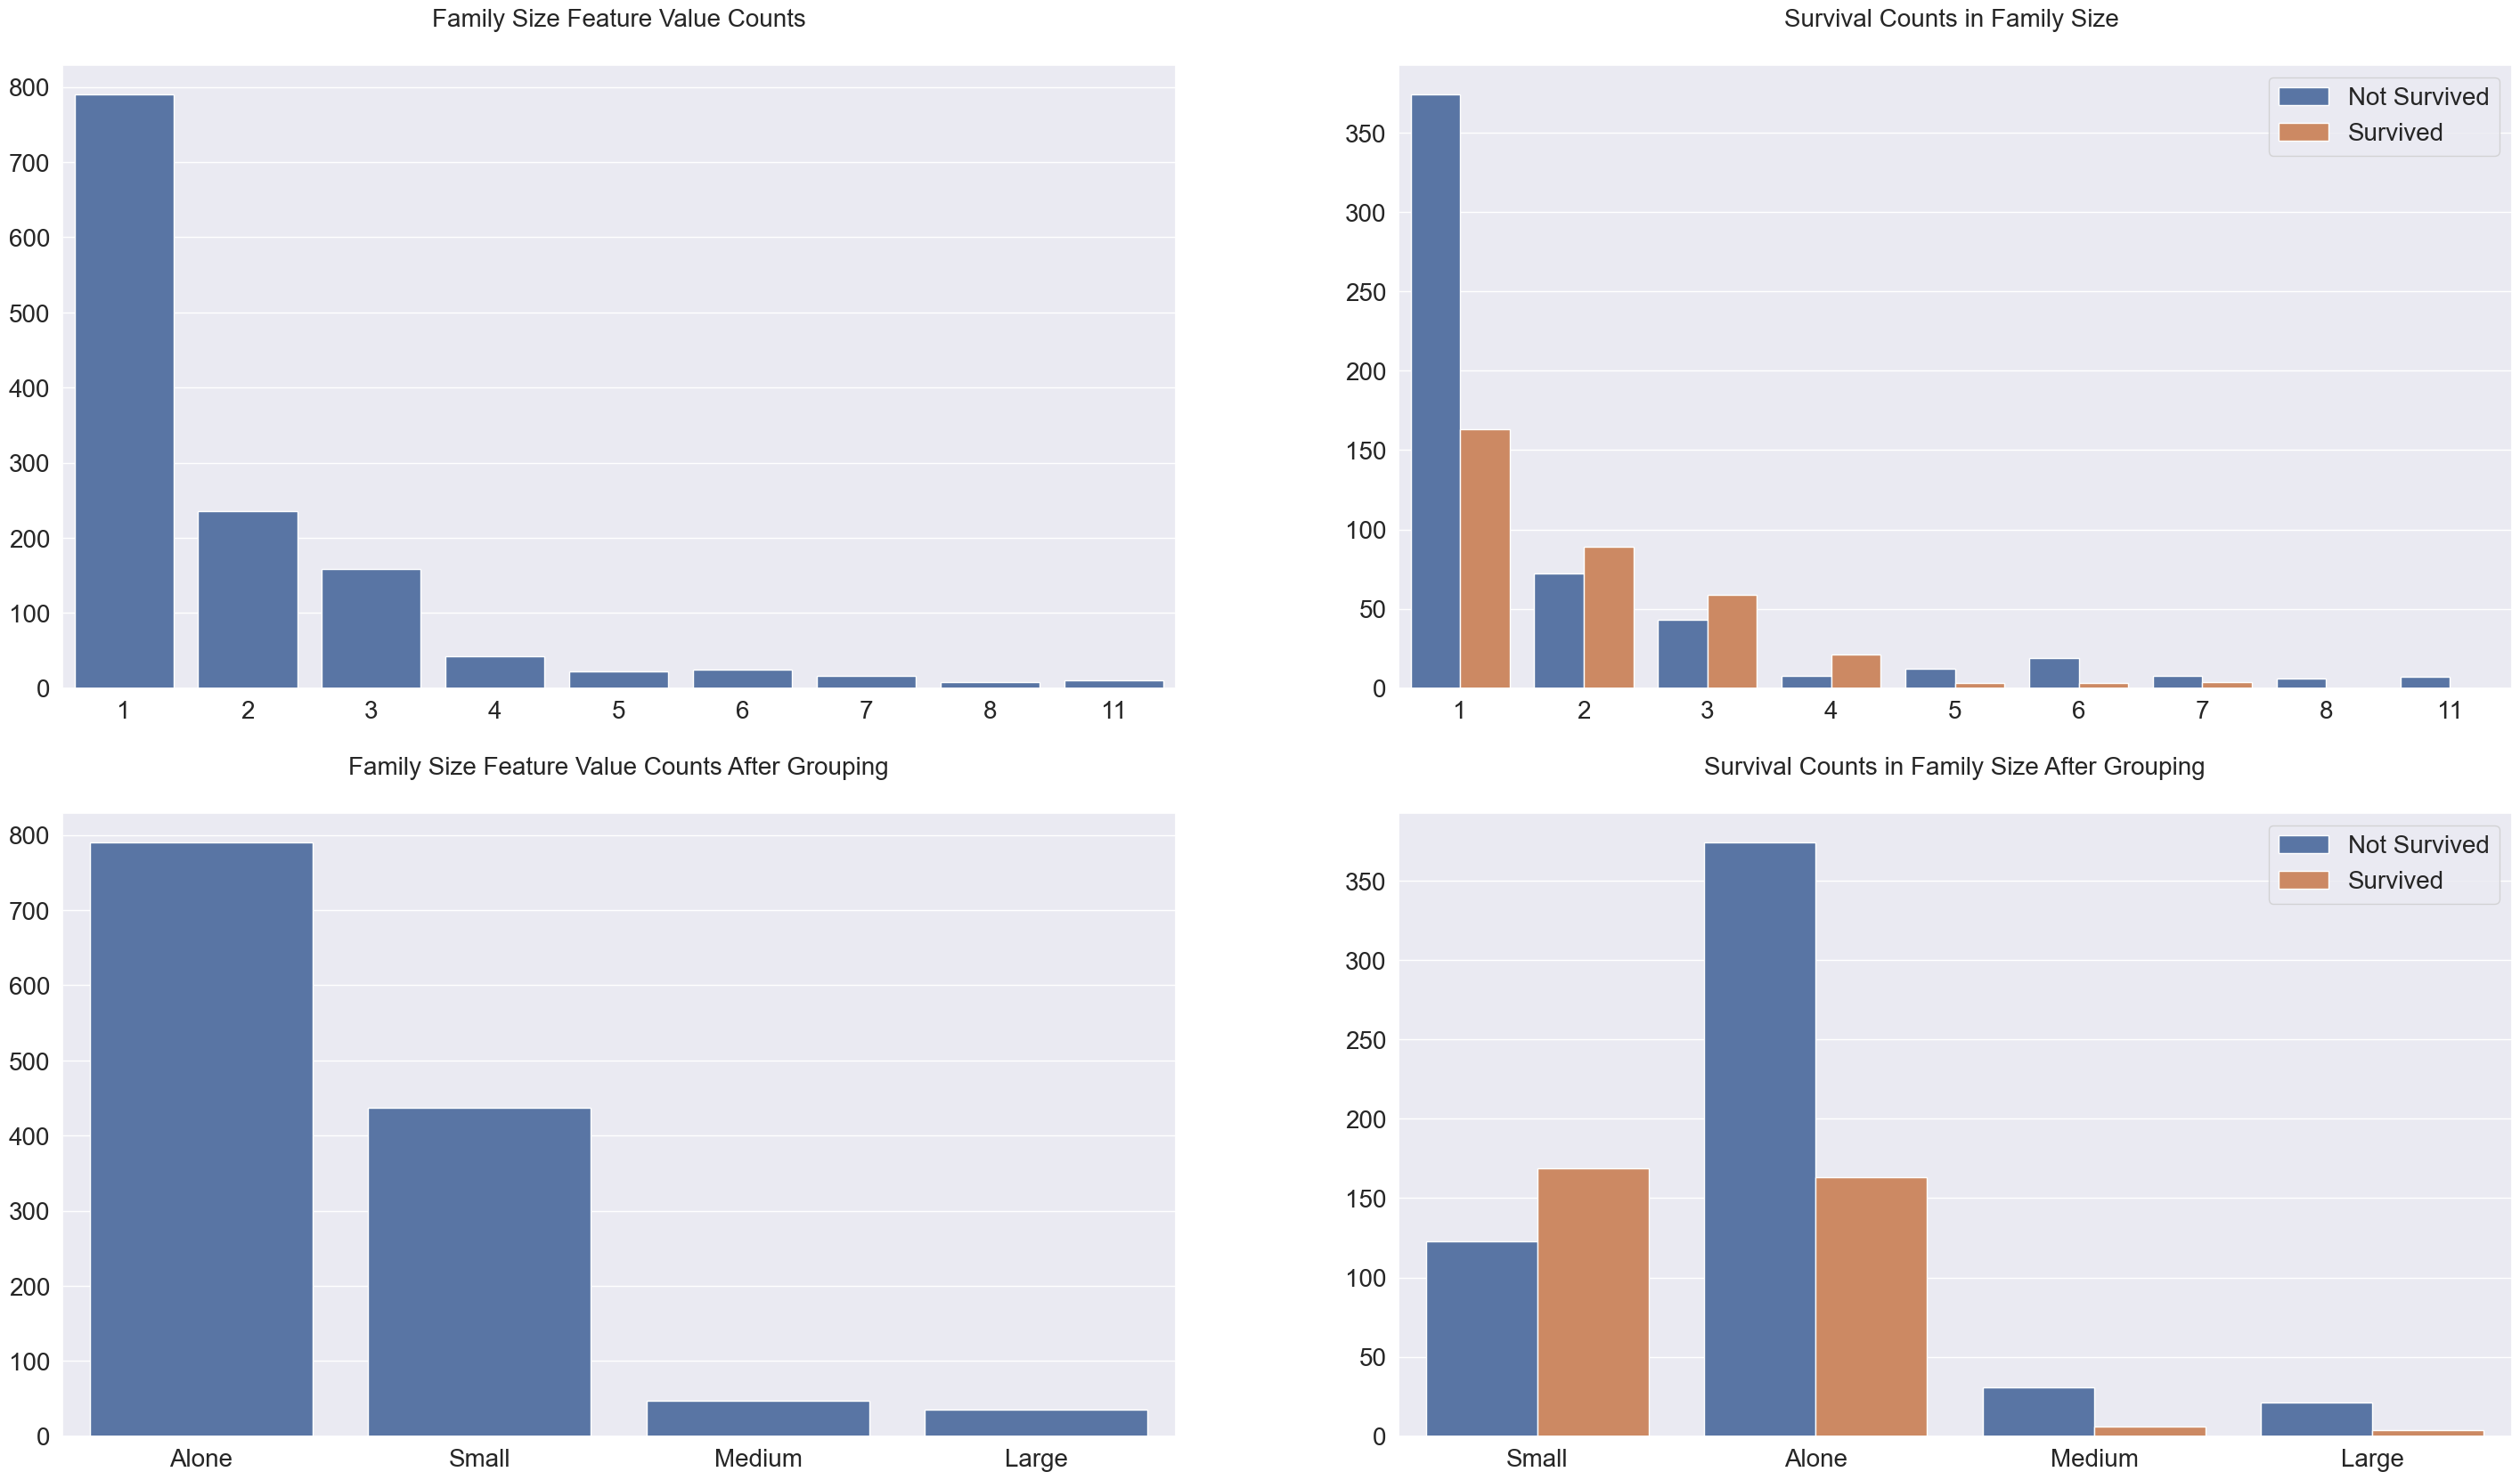

In [363]:
all['Family_Size'] = all['SibSp'] + all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=all['Family_Size'].value_counts().index, y=all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
all['Family_Size_Grouped'] = all['Family_Size'].map(family_map)

sns.barplot(x=all['Family_Size_Grouped'].value_counts().index, y=all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

We group `Ticket` values by their frequency.

In [364]:
all['Ticket_Frequency'] = all.groupby('Ticket')['Ticket'].transform('count')

Next we create an `Is_Married` feature.

In [365]:
all['Title'] = all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
all['Is_Married'] = 0
all['Is_Married'].loc[all['Title'] == 'Mrs'] = 1

Furthermore we extract specific titles.

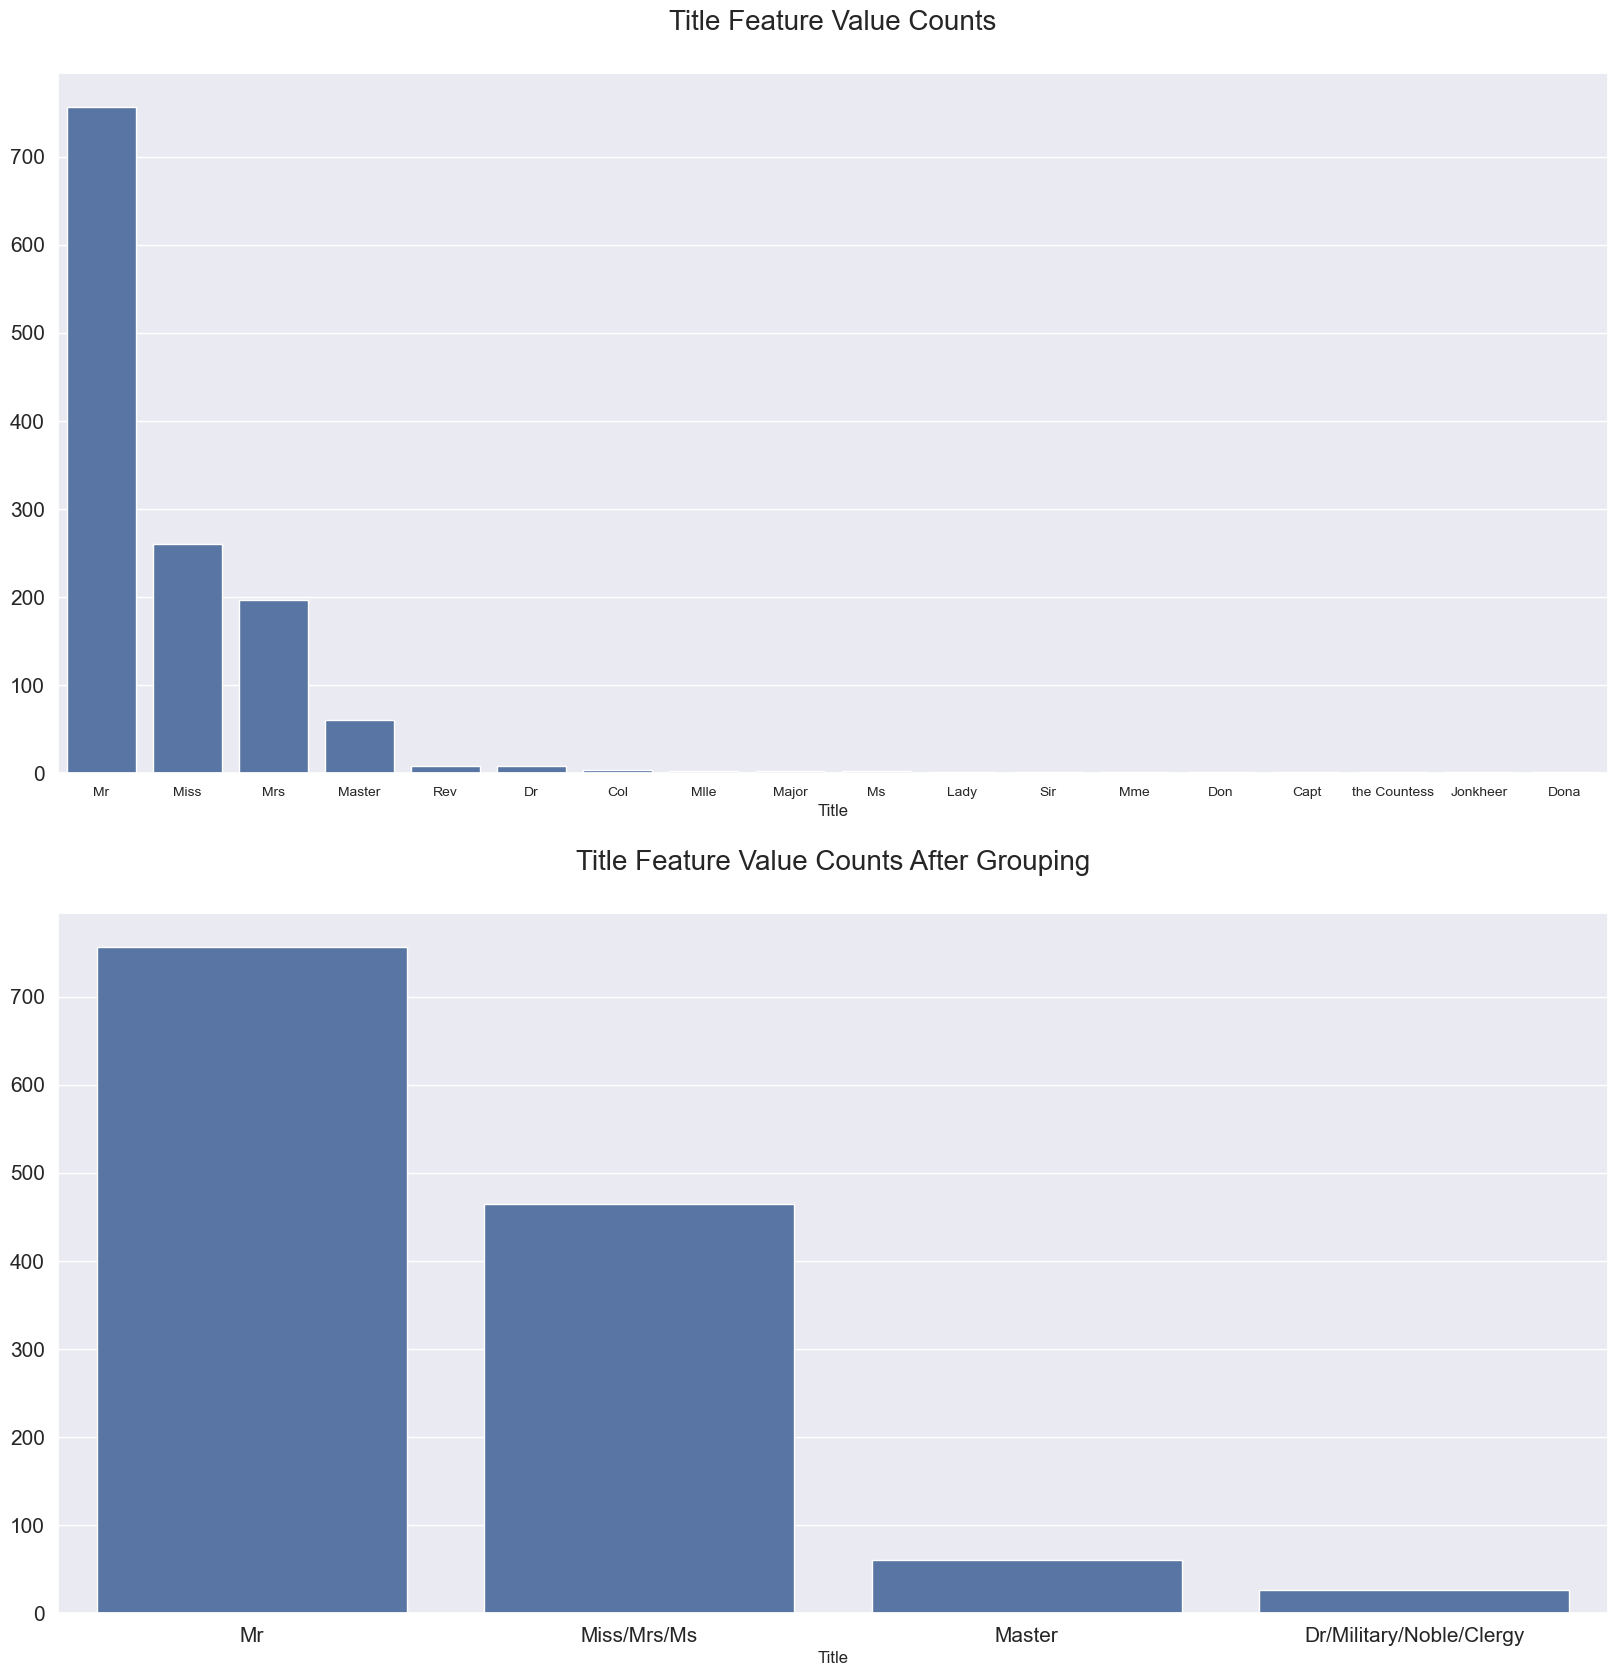

In [366]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=all['Title'].value_counts().index, y=all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

all['Title'] = all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
all['Title'] = all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=all['Title'].value_counts().index, y=all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

`extract_surname` function is used for extracting surnames of passengers from the Name feature. Family feature is created with the extracted surname. This is necessary for grouping passengers in the same family.

In [367]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

all['Family'] = extract_surname(all['Name'])
train = all.loc[:890]
test = all.loc[891:]
dfs = [train, test]

In [368]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in train['Family'].unique() if x in test['Family'].unique()]
non_unique_tickets = [x for x in train['Ticket'].unique() if x in test['Ticket'].unique()]

family_survival_rate = train.groupby('Family')[['Survived', 'Family','Family_Size']].median(numeric_only=True)
ticket_survival_rate = train.groupby('Ticket')[['Survived', 'Ticket','Ticket_Frequency']].median(numeric_only=True)

family_rates = {}
ticket_rates = {}

for i in range(len(family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if family_survival_rate.index[i] in non_unique_families and family_survival_rate.iloc[i, 1] > 1:
        family_rates[family_survival_rate.index[i]] = family_survival_rate.iloc[i, 0]

for i in range(len(ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if ticket_survival_rate.index[i] in non_unique_tickets and ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[ticket_survival_rate.index[i]] = ticket_survival_rate.iloc[i, 0]

In [369]:
mean_survival_rate = np.mean(train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(train)):
    if train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(test)):
    if test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
train['Family_Survival_Rate'] = train_family_survival_rate
train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
test['Family_Survival_Rate'] = test_family_survival_rate
test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(train)):
    if train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(test)):
    if test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
train['Ticket_Survival_Rate'] = train_ticket_survival_rate
train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
test['Ticket_Survival_Rate'] = test_ticket_survival_rate
test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [370]:
for df in [train, test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2    

## Feature transformation
***
We label encode non-numerical features.

In [371]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

We then one-hot encode categorical features.

In [372]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

train = pd.concat([train, *encoded_features[:6]], axis=1)
test = pd.concat([test, *encoded_features[6:]], axis=1)


... and finally we save the data!

In [373]:
train.to_csv('data/processedTrain.csv', index=False)
test.to_csv('data/processedTest.csv', index=False)
